Based on the example [here](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

# Imports

In [1]:
from importlib import reload
import os
import pickle as pkl
import time

In [2]:
import numpy as np
import pandas as pd
import seaborn as sbn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import tqdm

In [37]:
import dplyr_lite as d
import models_pyt as mo
import text_utils as tu

# Data

Downloaded publicly available pubmed abstracts.  
The data is pre-cleaned through regular expressions in `text_utils.cleanTxt`.  
Sentence ends are replaced "\</s>" tag.

In [4]:
abstracts = pd.read_csv('content/pubmed_cr_hep_ctl_abstracts_clean.csv')

In [5]:
abstracts.head(n = 3)

,pmid,label_cir,label_nfl,label_hep,label_hpc,txt
0,30558055,1,0,0,0,abo incompatible living donor liver transplant...
1,30558011,1,0,0,0,a human ciliopathy with polycystic ovarian syn...
2,30540737,1,0,0,0,vibrio cholerae no - o1 no - o139 bacteremia i...


In [6]:
abstracts.txt[0]

'abo incompatible living donor liver transplantation using dual grafts and pure laparoscopic donor right hepatectomy a case report </s> </s> rationale because of the shortage of deceased donors living donor liver transplantation ldlt has become the main procedure to treat patients with end - stage liver disease in asian countries </s> however many potential donors are excluded because of donor safety and graft volume issues </s> in addition large abdominal wounds after open surgery for hepatectomy could be a reason for hesitating to agree to liver donation particularly when attempting to recruit young female donors </s> patient concerns on volumetric computed tomography ct examination remnant liver volume was too small to guarantee the safety of the male donor and the right hemiliver volume of the female donor was not sufficient to meet the recipient metabolic demand </s> the young female donor also worried about a large abdominal wound following open surgery </s> interventions we perf

In [7]:
d.p(abstracts, d.count('label_hep'))

,label_hep,n
0,0,4458
1,1,2268


400 cutoff captures almost all information

In [8]:
sample_len = 400

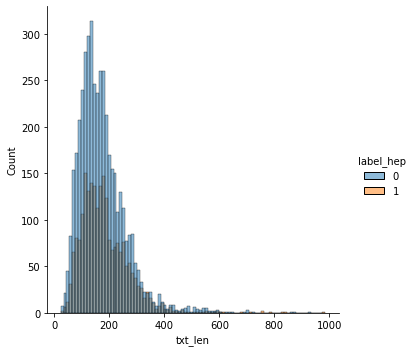

In [9]:
d.p(
    abstracts,
    d.mutate(txt_len = ('txt', lambda _: len(_.split(' ')))),
    lambda _: sbn.displot(data = _, x = 'txt_len', hue = 'label_hep')
)

# Tokenize, Numericize

In [26]:
vocab = tu.create_vocab(abstracts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6726/6726 [00:00<00:00, 9316.96it/s]


In [31]:
abstracts.txt[0][:30]

'abo incompatible living donor '

In [29]:
tu.numericize_sample(abstracts.txt[0][:30], vocab, 7)

array([3041, 3850,  480,  193,    0,    0,    0])

In [30]:
tu.numericize_sample(abstracts.txt[0], vocab, 7)

array([3041, 3850,  480,  193,   17,   80,  135])

# Data Loader

In [32]:
all_ixs = list(range(len(abstracts)))
ys = abstracts.label_hep.values

experiment_ixs, holdout_ixs = train_test_split(all_ixs, test_size=.15, stratify=ys)
train_ixs, val_ixs = train_test_split(experiment_ixs, test_size=.2, stratify=ys[experiment_ixs])

In [33]:
train_ixs[:5]

[4724, 1750, 3353, 850, 6354]

In [34]:
ixs_to_dataloader = lambda ixs, bs = 64, shuffle = True: tu.ixs_to_dataloader(
    ixs,
    abstracts,
    vocab,
    sample_len = sample_len,
    bs=bs,
    shuffle=shuffle
)

In [35]:
train_dataloader, val_dataloader, holdout_dataloader = [ 
    ixs_to_dataloader(_) 
    for _ in ( train_ixs, val_ixs, holdout_ixs ) 
]

# Train

In [40]:
def get_roc_auc(labels, pred_labels):
    return roc_auc_score(labels.detach().cpu(), pred_labels.softmax(1)[:, 1].detach().cpu())

def get_acc(labels, pred_labels):
    return (pred_labels.argmax(1) == labels).sum().item()

def train(dataloader, model, optimizer, criterion, epoch):
    model.train()
    total_auc, total_acc, total_count = 0, 0, 0
    log_interval = 10
    start_time = time.time()

    for idx, (nums, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        pred_labels = model(nums)
        loss = criterion(pred_labels, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_auc += get_roc_auc(labels, pred_labels)
        total_acc += get_acc(labels, pred_labels)
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| auc {:8.3f}'
                  '| acc {:8.3f}'.format(epoch, idx, len(dataloader),
                                         total_auc/(log_interval+1),
                                         total_acc/total_count * 100)
                 )
            total_auc, total_acc, total_count = 0, 0, 0
            start_time = time.time()
        

def evaluate(dataloader, model):
    model.eval()
    total_auc, total_acc, total_count = 0, 0, 0

    with torch.no_grad():
        for idx, (nums, labels) in enumerate(dataloader):
            pred_labels = model(nums)
            loss = criterion(pred_labels, labels)
            total_auc += get_roc_auc(labels, pred_labels)
            total_acc += get_acc(labels, pred_labels)
            total_count += labels.size(0)
    return total_auc/(idx + 1), total_acc/total_count

In [42]:
scan_cnn_1logit = mo.ScanCnn1Logit(sample_len, n_terms=len(vocab.vocab) + 1).to('cuda')

In [43]:
EPOCHS = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(scan_cnn_1logit.parameters(), lr=3.5e-4)
total_auc = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, scan_cnn_1logit, optimizer, criterion, epoch)
    auc_val, acc_val = evaluate(val_dataloader, scan_cnn_1logit)
    if total_auc is None or total_auc < auc_val:
        total_auc = auc_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid auc {:5.3f} | '
          'valid acc {:5.3f}'.format(epoch,
                                    time.time() - epoch_start_time,
                                    auc_val, acc_val))
    print('-' * 59)

/home/jod204/anaconda3/envs/jd_pyt_pip_keras_fastai/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


| epoch   1 |    10/   72 batches | auc    0.596| acc   45.881
| epoch   1 |    20/   72 batches | auc    0.566| acc   68.281
| epoch   1 |    30/   72 batches | auc    0.637| acc   68.281
| epoch   1 |    40/   72 batches | auc    0.722| acc   73.594
| epoch   1 |    50/   72 batches | auc    0.734| acc   68.906
| epoch   1 |    60/   72 batches | auc    0.799| acc   83.281
| epoch   1 |    70/   72 batches | auc    0.806| acc   75.469
-----------------------------------------------------------
| end of epoch   1 | time:  3.04s | valid auc 0.911 | valid acc 0.823
-----------------------------------------------------------
| epoch   2 |    10/   72 batches | auc    0.936| acc   84.943
| epoch   2 |    20/   72 batches | auc    0.855| acc   85.000
| epoch   2 |    30/   72 batches | auc    0.876| acc   88.438
| epoch   2 |    40/   72 batches | auc    0.887| acc   92.188
| epoch   2 |    50/   72 batches | auc    0.868| acc   89.688
| epoch   2 |    60/   72 batches | auc    0.880| acc 

# Holdout AUC

In [44]:
d.p(
    evaluate(holdout_dataloader, scan_cnn_1logit),
    lambda _: f'holdout AUC: {_[0]:.3f}; ACC: {_[1]:.3f}'
)

'holdout AUC: 0.966; ACC: 0.948'

# Save Model and Vocab

In [49]:
dst_dir = 'model_info'
if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)
    
mk_dst_f = lambda f: os.path.join(dst_dir, f)

with open(mk_dst_f('vocab.pkl'), 'wb') as f:
    pkl.dump(vocab, f)

scan_cnn_1logit.eval()
torch.save(scan_cnn_1logit.state_dict(), mk_dst_f('state_dict.pt'))

with open(mk_dst_f('ixs_lookup.pkl'), 'wb') as f:
    pkl.dump(
        {
            'train': train_ixs,
            'val': val_ixs,
            'holdout': holdout_ixs
        },
        f
    )